In [35]:

import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/movielens-20m-dataset/tag.csv
/kaggle/input/movielens-20m-dataset/rating.csv
/kaggle/input/movielens-20m-dataset/genome_scores.csv
/kaggle/input/movielens-20m-dataset/movie.csv
/kaggle/input/movielens-20m-dataset/genome_tags.csv
/kaggle/input/movielens-20m-dataset/link.csv


In [36]:
import warnings
import re
from PIL import Image
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [37]:
warnings.filterwarnings('ignore')

In [38]:
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth',-1)


In [39]:
movie=pd.read_csv('/kaggle/input/movielens-20m-dataset/movie.csv')
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [40]:
gen_tags=pd.read_csv('/kaggle/input/movielens-20m-dataset/genome_tags.csv')
gen_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [41]:
gen_scores=pd.read_csv('/kaggle/input/movielens-20m-dataset/genome_scores.csv')
gen_scores.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [42]:
def movie_title_clean(title):
    s=re.search('\(([^)]+)',title)
    year=9999
    if s:
        title=title[:s.span()[0]].strip()
        year=s.group(1)
        if str(year).isdigit():
            year=int(year)
        else:
            year=9999
    if title[-5:]== ',The':
        title= 'The' + title[-5:]
    elif title[-4:]== ',An':
        title= 'An' +title[-4:]
        
    elif title[-3:]== ',A':
        title= 'A' + title[-3:]
        
    return title,year

In [43]:
movie['title']=movie['title'].str.strip()
movie['title_year']=movie['title'].map(movie_title_clean)
movie['title']=movie['title_year'].apply(lambda x:x[0])
movie['Release Year']=movie['title_year'].apply(lambda x:x[1])

In [44]:
movie.head()

,movieId,title,genres,title_year,Release Year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,"(Toy Story, 1995)",1995
1,2,Jumanji,Adventure|Children|Fantasy,"(Jumanji, 1995)",1995
2,3,Grumpier Old Men,Comedy|Romance,"(Grumpier Old Men, 1995)",1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,"(Waiting to Exhale, 1995)",1995
4,5,Father of the Bride Part II,Comedy,"(Father of the Bride Part II, 1995)",1995


In [45]:
movie_stack= movie[movie['genres']!='(no genres listed)'].set_index('movieId').genres.str.split('|',expand= True).stack()
movie_explode=pd.get_dummies(movie_stack,prefix='g').groupby(level=0).sum().reset_index()

In [46]:
movie_explode['genre_vector']=movie_explode.iloc[:,1:].values.tolist()

In [47]:
movie_explode.head(3)

,movieId,g_Action,g_Adventure,g_Animation,g_Children,g_Comedy,g_Crime,g_Documentary,g_Drama,g_Fantasy,g_Film-Noir,g_Horror,g_IMAX,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Thriller,g_War,g_Western,genre_vector
0,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"


In [48]:
movie=movie.merge(movie_explode[['movieId','genre_vector']], on='movieId', how='left')

In [49]:
movie.head()

,movieId,title,genres,title_year,Release Year,genre_vector
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,"(Toy Story, 1995)",1995,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,2,Jumanji,Adventure|Children|Fantasy,"(Jumanji, 1995)",1995,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,3,Grumpier Old Men,Comedy|Romance,"(Grumpier Old Men, 1995)",1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
3,4,Waiting to Exhale,Comedy|Drama|Romance,"(Waiting to Exhale, 1995)",1995,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
4,5,Father of the Bride Part II,Comedy,"(Father of the Bride Part II, 1995)",1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [50]:
len(np.unique(gen_tags.tagId.values))

1128

In [51]:
len(np.unique(gen_scores.movieId.values))

10381

In [52]:
len(gen_scores)

11709768

In [53]:
gen_scores_denorm=gen_scores.merge(gen_tags,on='tagId').merge(movie,on='movieId')
gen_scores_denorm['relevance_rank']= gen_scores_denorm.groupby("movieId")["relevance"].rank(method="first",ascending=False).astype('int64')

In [54]:
gen_scores_denorm[gen_scores_denorm.title == 'Remember the Titans'][['movieId','title','tag','relevance','relevance_rank']].sort_values(by='relevance',ascending=False).head(10)

,movieId,title,tag,relevance,relevance_rank
3896511,3916,Remember the Titans,football,0.99600,1
3897070,3916,Remember the Titans,sports,0.98600,2
3896944,3916,Remember the Titans,race issues,0.97625,3
3896498,3916,Remember the Titans,feel good movie,0.96200,4
3896226,3916,Remember the Titans,based on true story,0.95175,5
3896499,3916,Remember the Titans,feel-good,0.94825,6
3896221,3916,Remember the Titans,based on a true story,0.93975,7
3896660,3916,Remember the Titans,inspiring,0.93650,8
3896614,3916,Remember the Titans,high school,0.93025,9
3896659,3916,Remember the Titans,inspirational,0.92550,10


In [55]:
gen_scores_rank_agg= gen_scores_denorm.groupby('relevance_rank')['relevance'].median().reset_index(name='relevance_median').head(100)
gen_scores_rank_agg['relevance_median_perc_change']=gen_scores_rank_agg['relevance_median'].pct_change()

Text(0.5, 1.0, 'Boxplot: Tag relevance score by rank')

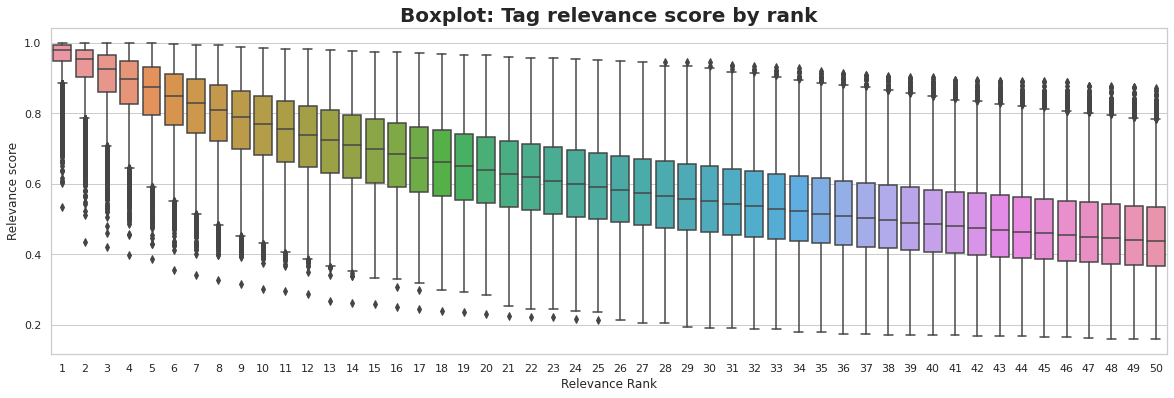

In [56]:
sns.set(style='whitegrid')
f,ax=plt.subplots(figsize=(20,6))
ax=sns.boxplot(x='relevance_rank',y='relevance',data=gen_scores_denorm[gen_scores_denorm.relevance_rank <=50], showfliers=True)
ax.set(ylabel='Relevance score')
ax.set(xlabel='Relevance Rank')
plt.title('Boxplot: Tag relevance score by rank', fontsize=20, weight='bold')

In [57]:
gen_scores_list=gen_scores_denorm[gen_scores_denorm.relevance_rank <=100].groupby(['movieId','title'])['tag'].apply(lambda x: ','.join(x)).reset_index()
gen_scores_list['tag_list']=gen_scores_list.tag.map( lambda x:x.split(','))

In [58]:
gen_scores_list.head(1)

,movieId,title,tag,tag_list
0,1,Toy Story,"3d,action,adventure,affectionate,animal movie,animals,animated,animation,based on book,cartoon,catastrophe,cgi,chase,childhood,children,classic,clever,colourful,comedy,computer animation,cool,creativity,cute,cute!,destiny,dialogue,disney,disney animated feature,entertaining,excellent,excellent script,exciting,fairy tale,family,fantasy,fantasy world,fast paced,feel good movie,feel-good,friendship,fun,fun movie,funny,good,good acting,good soundtrack,good story,good versus evil,goofy,great,great ending,great movie,happy ending,heartwarming,highly quotable,humor,humorous,imagination,imdb top 250,intense,interesting,kids,kids and family,light,mentor,monsters,movielens top pick,nostalgic,original,original plot,oscar,oscar (best animated feature),oscar (best directing),oscar (best effects - visual effects),oscar winner,pg-13,pixar,pixar animation,quotable,redemption,runaway,sentimental,simple,space,story,storytelling,suspense,sweet,talking animals,talky,technology,touching,toys,transformation,unlikely friendships,very funny,very good,visual,whimsical,witty","[3d, action, adventure, affectionate, animal movie, animals, animated, animation, based on book, cartoon, catastrophe, cgi, chase, childhood, children, classic, clever, colourful, comedy, computer animation, cool, creativity, cute, cute!, destiny, dialogue, disney, disney animated feature, entertaining, excellent, excellent script, exciting, fairy tale, family, fantasy, fantasy world, fast paced, feel good movie, feel-good, friendship, fun, fun movie, funny, good, good acting, good soundtrack, good story, good versus evil, goofy, great, great ending, great movie, happy ending, heartwarming, highly quotable, humor, humorous, imagination, imdb top 250, intense, interesting, kids, kids and family, light, mentor, monsters, movielens top pick, nostalgic, original, original plot, oscar, oscar (best animated feature), oscar (best directing), oscar (best effects - visual effects), oscar winner, pg-13, pixar, pixar animation, quotable, redemption, runaway, sentimental, simple, space, story, storytelling, suspense, sweet, talking animals, talky, technology, touching, toys, transformation, unlikely friendships, very funny, very good, visual, whimsical, witty]"


In [61]:
pd.set_option('display.max_colwidth',-1)
gen_scores_list.loc[gen_scores_list.title =='Good Will Hunting',['movieId','title','tag_list']]

,movieId,title,tag_list
1498,1704,Good Will Hunting,"[bittersweet, boston, cerebral, character study, childhood, classic, clever, college, coming of age, complex, complex characters, corruption, courage, depression, destiny, dialogue, dialogue driven, drama, dramatic, drinking, earnest, emotional, excellent, excellent script, exceptional acting, existentialism, feel good movie, feel-good, foul language, friendship, genius, good, good acting, good dialogue, good soundtrack, good story, great, great acting, great dialogue, great ending, great movie, happy ending, heartwarming, highly quotable, honest, hunting, idealism, imdb top 250, inspirational, inspiring, intellectual, intelligent, intense, interesting, life, life philosophy, literature, loneliness, love, love story, math, mathematics, mentor, narrated, original, original plot, oscar, oscar (best actor), oscar (best actress), oscar (best directing), oscar (best picture), oscar (best supporting actor), oscar (best supporting actress), oscar (best writing - screenplay written directly for the screen), oscar winner, pg-13, philosophy, plot, poignant, psychiatry, psychology, quotable, rags to riches, realistic, redemption, reflective, relationships, sappy, sentimental, social commentary, story, storytelling, suprisingly clever, talky, thought-provoking, touching, underdog, unlikely friendships, very good, writing]"


In [62]:
pd.reset_option('display.max_colwidth')

target_movie = 'Interstellar'

target_tag_list = gen_scores_list[gen_scores_list.title == target_movie].tag_list.values[0]
gen_scores_list_sim = gen_scores_list[['movieId','title','tag_list','tag']]
gen_scores_list_sim['jaccard_sim'] = gen_scores_list_sim.tag_list.map(lambda x: len(set(x).intersection(set(target_tag_list))) / len(set(x).union(set(target_tag_list))))
print(f'Movies most similar to {target_movie} based on tags:')
text = ','.join(gen_scores_list_sim.sort_values(by = 'jaccard_sim', ascending = False).head(25)['tag'].values)
gen_scores_list_sim.sort_values(by = 'jaccard_sim', ascending = False).head(10)

Movies most similar to Interstellar based on tags:


,movieId,title,tag_list,tag,jaccard_sim
10046,109487,Interstellar,"[70mm, adventure, amazing cinematography, amaz...","70mm,adventure,amazing cinematography,amazing ...",1.000000
8055,52328,Sunshine,"[alien, aliens, allegory, amazing cinematograp...","alien,aliens,allegory,amazing cinematography,a...",0.503759
9803,101864,Oblivion,"[action, adapted from:comic, adventure, alien,...","action,adapted from:comic,adventure,alien,alie...",0.503759
9915,104841,Gravity,"[3d, action, allegory, amazing cinematography,...","3d,action,allegory,amazing cinematography,amaz...",0.470588
1452,1653,Gattaca,"[allegory, alone in the world, amazing cinemat...","allegory,alone in the world,amazing cinematogr...",0.459854
1390,1584,Contact,"[adapted from:book, adventure, alien, alien in...","adapted from:book,adventure,alien,alien invasi...",0.459854
10220,114935,Predestination,"[absurd, adaptation, allegory, alternate endin...","absurd,adaptation,allegory,alternate endings,a...",0.449275
9676,97752,Cloud Atlas,"[1930s, 19th century, adaptation, adapted from...","1930s,19th century,adaptation,adapted from:boo...",0.428571
3864,4370,A.I. Artificial Intelligence,"[adventure, alien, aliens, allegory, alone in ...","adventure,alien,aliens,allegory,alone in the w...",0.428571
8696,68237,Moon,"[androids, artificial intelligence, astronauts...","androids,artificial intelligence,astronauts,at...",0.428571


In [ ]:
pd.reset_option('display.max_colwidth')

target_movie = 'Toy Story'

target_tag_list = gen_scores_list[gen_scores_list.title == target_movie].tag_list.values[0]
gen_scores_list_sim = gen_scores_list[['movieId','title','tag_list','tag']]
gen_scores_list_sim['jaccard_sim'] = gen_scores_list_sim.tag_list.map(lambda x: len(set(x).intersection(set(target_tag_list))) / len(set(x).union(set(target_tag_list))))
print(f'Movies most similar to {target_movie} based on tags:')
text = ','.join(gen_scores_list_sim.sort_values(by = 'jaccard_sim', ascending = False).head(25)['tag'].values)
gen_scores_list_sim.sort_values(by = 'jaccard_sim', ascending = False).head(10)